# Network Degeneracy as an Indicator of Training Performance
### (MNIST Data)
This notebook provides a summarized version of the code used to produce Figure 1 of *Network Degeneracy as an Indicator of Training Performance: Comparing Finite and Infinite Width Angle Predictions* (Jakub and Nica, 2023b). This notebook will use the MNIST dataset (Deng, 2012) smaller number of networks, and only 2 runs to allow it to run quickly on CoLab. The simulations ran in our paper used 45 different network architectures, ran 10 times each.

You may run into issues with RAM if you try to run many runs of many architectures at once. Code is provided at the end of the notebook to save results, so you can run this notebook multiple times in smaller chunks and consolidate the results afterwards.

Author: Cameron Jakub

In [ ]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import math
import tensorflow as tf
import pickle
import os

from tensorflow.keras import datasets, layers, models
from keras.models import Sequential # sequential is the feed forward NN
from keras.layers.core import Dense, Dropout, Activation  # layer types
from keras.utils import np_utils
from matplotlib.pyplot import figure
from google.colab import output
from pathlib import Path

# Load & Prepare MNIST Data

In [ ]:
# import the MNIST dataset
from keras.datasets import mnist

# Split into test and train, and X and Y variables
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


Plot an image

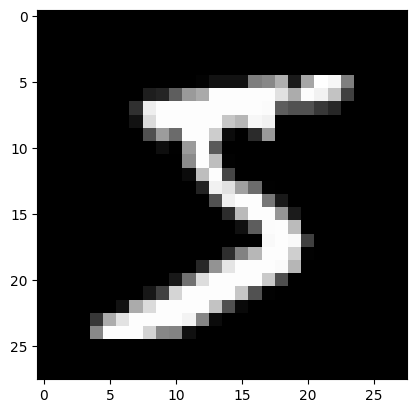

In [ ]:
# Change the value of img to look at different images
img = 0
plt.gray()
plt.imshow(train_X[img,:,:]);

In order to fit our data to a neural network, we first need to reshape the data to be a vector. Each image is $28 \times 28$ pixels, so we can fit the data into a vector of size $784$. We then normalize the data.

In [ ]:
# Reshape
train_X = train_X.reshape(60000, 784)
test_X = test_X.reshape(10000, 784)

# Convert from integer to float
train_X = train_X.astype('float32')

# Normalize
train_X = train_X/255
test_X = test_X/255

Now we convert the y vectors (target) to a matrix of classes, with a 1 in the appropriate class.

In [ ]:
train_y = np_utils.to_categorical(train_Y, 10)
test_y = np_utils.to_categorical(test_Y, 10)
test_y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Create the Networks
We want to run each model multiple times, so we can create a confidence interval for the performance of each network. Here, we can specify number of times we want each model to run.

In [ ]:
N_runs = 2

Specify hyperparameters.

In [ ]:
# batch size
N_batch = 100

# epochs
N_epoch = 1

We are studying feed-forward ReLU networks with depth $L$ and layer widths $1\leq \ell \leq L$. First, we can formally define a network $f_L(x): \mathbb{R}^{n_{in}} \to \mathbb{R}^{n_{out}}$. Given some input $x \in \mathbb{R}^{n_{in}}$, the first hidden layer of our network $z^1$ can be calculated as

$$ z^1 = W^1x,$$

where $W^1 \in \mathbb{R}^{n_1 \times n_{in}}$ is a matrix of weights. To get from layer $\ell$ to layer $\ell+1$, we take the current layer and
* apply the ReLU activation function $\varphi(x)$ entry-wise
* multiply by weight matrix $W^{\ell+1}$
* apply a normalization constant of $\sqrt{2/n_\ell}$

$$ z^{\ell+1} = \sqrt{\frac{2}{n_\ell}}W^{\ell+1} \varphi(z^\ell) $$

Finally, the output of our network is simply the final layer of the network.

$$ f_L(x) = z^L.$$

### Details on the Normalization Constant

The normalization constant we use is known as the "He" normalization constant (He et al., 2015). To account for this in our code, we specify the kernel initializer to be 'HeNormal" for each layer. You may notice that this normalization constant does not appear in our calculation of the first hidden layer, $z_1$. It is common in practice to skip the normalization in the first layer, but if we don't normalize each subsequent layer, it can cause the nodes of our network to become extremely large. This is because each node of layer $\ell+1$ is calculated as the inner product between the current layer $z^\ell$ and the corresponding row of the weight matrix $W^{\ell+1}$. Each inner product is a **sum** of $n_\ell$ numbers, so without normalization, these numbers would grow unbounded layer by layer. Including the normalization constant turns the sums over $n_\ell$ numbers into an **average** over $n_\ell$ numbers, preventing them from "blowing up".

For a classification problem like this one, whether we include the normalization constant or not in the first layer is equivalent to changing the temperature of the softmax function, which will not actually change how the networks classify the digits. The softmax function is defined as

$$\textrm{softmax}(z)_i = \frac{e^{\frac{z_i}{T}}}{\sum_{j=1}^K e^{\frac{z_j}{T}}} ,$$
where $z$ is the input vector, $K$ is the number of classes, and $T$ is the temperature of the function.

To be more consistent with our update rule, which was developed to predict how the inputs evolve from one *hidden layer*  to the next, we will include the normalization in the first layer - ie. $z_1 = \sqrt{2/n_\ell}W^1 x$, knowing that this will not actually affect the test accuracy of each network.


We want to compare the training performance of multiple networks with various architectures. To do this easily, we create a function that will create our model based on a vector of ordered layer widths given to it.

In [ ]:
# function which returns your model based on the architecture its fed
def create_model(layers):
  depth = len(layers)
  mdl = Sequential() # sequential represents a feed-forward nnet

  # add first hidden layer
  mdl.add(Dense(layers[0], input_shape=(784,), use_bias = False, kernel_initializer = 'HeNormal'))

  # add activation function
  mdl.add(Activation('relu'))

  # add rest of hidden layers
  for i in range(1, depth):
    mdl.add(Dense(layers[i], use_bias = False, kernel_initializer = 'HeNormal'))
    mdl.add(Activation('relu'))

  # add output layer
  mdl.add(Dense(10, use_bias = False, kernel_initializer = 'HeNormal'))

  # convert output vector to a probability vector w/ softmax
  mdl.add(Activation('softmax'))

  return mdl

Now we create a function which takes a model, compiles and trains the model, and outputs the model's test accuracy.

In [ ]:
def model_score(mdl):
  # compile the model
  mdl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # train the model
  mdl.fit(train_X, train_y, batch_size=N_batch, epochs=N_epoch, verbose=1)

  # extract the test accuracy of the model
  score = mdl.evaluate(test_X, test_y)[1]

  return score

Now we just need to create a bunch of model architectures, which we will define as an ordered list of hidden layer widths.

In [ ]:
layer_widths = []

layer_widths.append(np.tile(85,2).tolist())
layer_widths.append(np.tile(100, 10).tolist())
layer_widths.append(np.tile(30, 15).tolist())
layer_widths.append(np.tile(15,30).tolist())
layer_widths.append(np.tile(75,35).tolist())
layer_widths.append(np.tile(50, 50).tolist())

Now let's create and train each model. For the purpose of keeping track of observations, we will also assign each model a number and keep track of the order in which each model ran. To create a plot, we also want to save the number of parameters in each model, as well as the "score" of each model, representing its classification accuracy on the test data.

Note: the below cell may take many minutes to run, as this is where we create, train, and evaluate each of the models created.

In [ ]:
models = [create_model(l) for l in layer_widths*N_runs]
model_num = [i for i,x in list(enumerate(layer_widths))*N_runs]

params = [m.count_params() for m in models]
scores = [model_score(m) for m in models]

313/313 [==============================] - 1s 3ms/step - loss: 1.6938 - accuracy: 0.2022


# Predict the Angle at Layer $L$

At the core of our predictions is the function $\mu(\theta,n)$, defined in Theorem 1 of Jakub and Nica (2023a). Given the angle between inputs at the current layer ($\theta^\ell$), the function $\mu(\theta_\ell, n_\ell)$ is used to approximate $\ln(\sin^2(\theta^{\ell+1}))$:

$$\mathbf{E}[\ln(\sin^2(\theta^{\ell+1}))] = \mu(\theta^\ell, n_\ell) + \mathcal{O}(n_\ell^{-2}).$$

We define $\mu$ in terms of a family of $J$ functions which represent the joint moments of the ReLU activation function applied to Gaussian variables. For more on the $J$ functions, see Section 3 of Jakub and Nica (2023a).

Here, we define the necessary $J$ functions ($J_{1,1}(\theta), J_{2,2}(\theta), J_{3,1}(\theta)$).

In [ ]:
j11 = lambda th: (np.sin(th) + (np.pi - th)*np.cos(th))/(2*np.pi)

j22 = lambda th: ((np.pi-th)*(2*np.cos(th)**2 + 1) + 3*np.sin(th)*np.cos(th))/(2*np.pi)

j31 = lambda th: (3*(np.pi-th)*np.cos(th) + np.sin(th)*np.cos(th)**2 + 2*np.sin(th))/(2*np.pi)

Now, define our formula for $\mu(\theta, n)$ in terms of the $J$ functions:

$$\mu(\theta,n) := \ln \left( \frac{(n-1)(1-4J_{1,1}^2)}{4J_{2,2}-1+n}\right)+ \frac{ 4(J_{2,2}+1)}{n\left(\frac{4J_{2,2}-1}{n}+1\right)^2}-  \frac{4\left(8J_{1,1}^2J_{2,2} - 8J_{1,1}^4 + 4J_{1,1}^2 - 8J_{1,1}J_{3,1} + J_{2,2} + 1 \right) }{n\left( 1-\frac{1}{n} \right)^2 \left( 1 - 4 J_{1,1}^2 \right)^2 }. $$



In [ ]:
def mu(th, n):
  return np.log((n-1)*(1-4*j11(th)**2)/(4*j22(th)-1+n)) \
         + 4*(j22(th)+1)/(n*((4*j22(th)-1)/n + 1)**2) \
         - 4*(8*j11(th)**2*j22(th) - 8*j11(th)**4 + 4*j11(th)**2 - 8*j11(th)*j31(th) + j22(th) +1) \
         /((n-1)**2*(1-4*j11(th)**2)**2/n)

We now have $\mu$ properly defined, which is at the heart of our prediction algorithm. Using the width of each layer, we can predict the angle between 2 orthogonal inputs at the final layer of each network.

$$ \ln(\sin^2(\theta^{\ell+1})) = \mu(\theta^\ell, n_\ell).$$


In [ ]:
def theta_L(width_vector):
  net_depth = np.shape(width_vector)[0]-1

  # Create vector to store theta values at each layer
  theta = np.zeros((net_depth+1,1))

  # Create the starting angle, representing orthogonal inputs
  theta[0] = np.pi/2

  # loop to predict theta at layer L
  for i in range(net_depth):
    # predict E[ln(sin^2(th))] at the next layer
    ln_sinsq_th = mu(theta[i], width_vector[i])

    # convert ln(sin^2(th)) back to th
    theta[i+1] = np.arcsin(np.exp(ln_sinsq_th/2))

  return theta[net_depth][0]

To get the full architecture of the network, we will add the dimension of the input and output layer to our vector of hidden layer widths.

In [ ]:
N_in = 784
N_out = 10

for l in layer_widths:
  l.insert(0,N_in)
  l.append(N_out)

We are now ready to compute the final angle between inputs for each trained network:

In [ ]:
thetas = [theta_L(l) for l in layer_widths*N_runs]

# Plotting
We want to create error bars for each network used. To do this, we group together observations which came from the same network architectures.


In [ ]:
def plot_data(params, thetas, model_num, scores):
  # for repeated runs of the same architecture, the final predicted angle and
  # the number of parameters will not change. Therefore, for each architecure,
  # we only need to store this value once
  thetas_plot = [thetas[i] for i in set(model_num)]
  params_plot = [params[i] for i in set(model_num)]

  # For each architecture, we want to use the multiple runs to create an error
  # bar for test performance. Here, we use the multiple runs to calculate the
  # mean and error margin for a 95% confidence interval
  means = []
  err_margins = []

  for n in set(model_num):
    # find the indices of the current model
    idx = [i for i,j in enumerate(model_num) if j==n]

    # create an error bar for the scores corresponding to current theta value
    theta_scores = [scores[i] for i in idx]

    # calculate the mean
    means.append(np.mean(theta_scores))

    # calculate standard error
    std_error = np.std(theta_scores)/np.sqrt(10)
    err_margins.append(std_error*1.96)

  return params_plot, thetas_plot, means, err_margins

We will express the colorbar in terms of $\log_{10}(\# \textrm{ of parameters})$, and we will plot the $\theta$ values on the $x$ axis as $\ln(\sin^2(\theta))$ to be consistent with $\mu(\theta,n)$, which we used to predict $\mathbf{E}[\ln(\sin^2(\theta))]$.

In [ ]:
params_plot, thetas_plot, means, err_margins = plot_data(params, thetas, model_num, scores)

log_params = [math.log10(p) for p in params_plot]
log_thetas = [np.log(np.sin(th)**2) for th in thetas_plot]

Finally, we are ready to plot the results.

<ErrorbarContainer object of 3 artists>

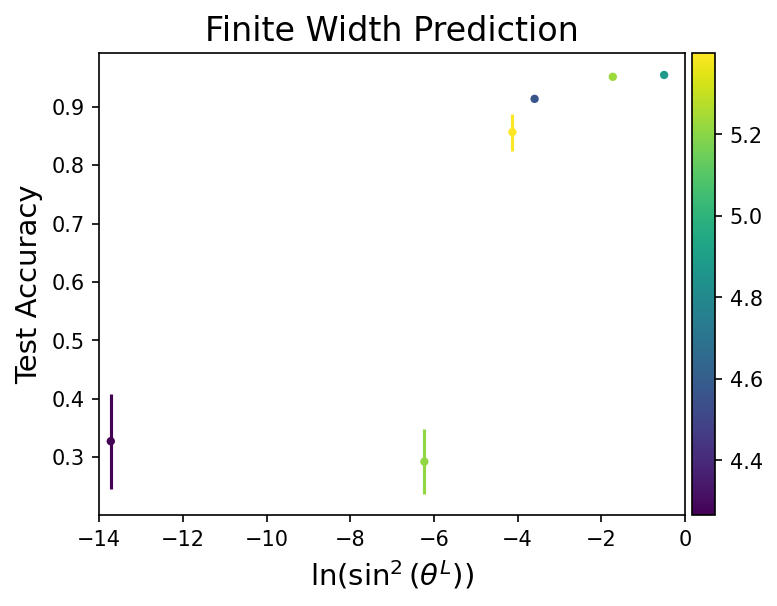

In [ ]:
# Plot
plt.figure(figsize=(6, 4), dpi = 150)

plt.scatter(log_thetas, means, c = log_params, cmap = 'viridis', marker = '.')
plt.xlim([-14,0])
plt.xlabel("$\\ln(\\sin^2(\\theta^L))$", fontsize = 14)
plt.ylabel("Test Accuracy", fontsize = 14)
plt.title('Finite Width Prediction', fontsize = 16)

# add in colourbar
cbar = plt.colorbar(pad=0.01)

# add in coloured error bars
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize()
plt.errorbar(log_thetas, means, yerr=err_margins, ls='none', ecolor = cmap(norm(log_params)))

# Optional: Save Plotting Data to Google Drive
If you wish to run and plot many network architectures at once, it is likely you will run out of available RAM on CoLab. The below code can be used to save your results to a file on your Google Drive. You can then change the network architectures and re-run the notebook, and the results will be appended to the files created on the first run.

In [ ]:
# mount google drive to save files
from google.colab import drive
drive.mount('/content/drive/')

Here we make 2 functions which allow us to retrieve data from old runs, and update files on our Google Drive to include the data from new runs.

In [ ]:
def retrieve_file(path):
  with open(path, 'rb') as fp:
    return pickle.load(fp)

def update_file(path, data):
  with open(path, 'wb') as fp:
    pickle.dump(data, fp)

In [ ]:
# specify path which data will be saved in your Google Drive
mypath = Path('/content/drive/My Drive/insert_path') # update this line with your desired path

# create the path names for each of the files you will be saving
params_path = Path.joinpath(mypath, 'params_file')
thetas_path = Path.joinpath(mypath, 'thetas_file')
means_path = Path.joinpath(mypath, 'mean_score_file')
err_margins_path = Path.joinpath(mypath, 'err_margins_file')

# check if these files have been saved before
if os.path.exists(params_path):

  # open files from previous runs
  params_old = retrieve_file(params_path)
  thetas_old = retrieve_file(thetas_path)
  means_old = retrieve_file(means_path)
  err_margins_old = retrieve_file(err_margins_path)

  # Extend the current lists to include the data from past runs
  params_plot.extend(params_old)
  thetas_plot.extend(thetas_old)
  means.extend(means_old)
  err_margins.extend(err_margins_old)

Now that our variables include all the data from the current run, plus the data from previous runs, we can update the files on our drive.

In [ ]:
params_old = update_file(params_path, params_plot)
thetas_old = update_file(thetas_path, thetas_plot)
means_old = update_file(means_path, means)
err_margins_old = update_file(err_margins_path, err_margins)

# References
Li Deng. The MNIST database of handwritten digit images for machine learning research.
IEEE Signal Processing Magazine, 29(6):141–142, 2012.

Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Delving deep into recti-
fiers: Surpassing human-level performance on imagenet classification. In 2015 IEEE
International Conference on Computer Vision (ICCV), pages 1026–1034, 2015. doi:
10.1109/ICCV.2015.123

Cameron Jakub and Mihai Nica. Depth degeneracy in neural networks: Vanishing angles in
fully connected ReLU networks on initialization, 2023a. URL https://arxiv.org/abs/2302.09712

Cameron Jakub and Mihai Nica. Network degeneracy as an indicator of training performance: Comparing finite and infinite width angle predictions, 2023b. URL https://arxiv.org/abs/2306.01513

